# Notebook 08: LOO Relative Performance Regression
## LinkedIn Engagement Prediction — TrendPilot

**Approach:** Leave-One-Out (LOO) Relative Engagement Regression
**Date:** February 2026
**Follows:** `06_model_training_v4_FIXED.ipynb`
**Plan doc:** `reports/08_model_improvement_PLAN.md`

---

## Why This Approach?

Previous models (NB06 v4 FIXED) all produced **negative R squared** on the test set.

**Root causes:**
1. **Severely skewed targets** — Reactions: mean=353, median=64. Viral posts dominate the loss function.
2. **Content features cannot predict absolute engagement** — 70-80% of raw engagement variance is explained by *who posted* (audience size), not *what was posted*. With influencer features removed, the model has no baseline to work from.
3. **Wrong problem formulation** — A post with 200 reactions means nothing without context. From an author who averages 50 reactions it is excellent (4x). From one who averages 1000 it is poor (0.2x).

**Solution — LOO Relative Targets:**

    relative_reactions = reactions / author_loo_median_reactions
    log_relative       = log(relative_reactions)

- The author's audience size is divided out — content features now explain deviations from the baseline
- Log-transform makes the distribution approximately normal (fixing skewness)
- LOO prevents data leakage: each post's author baseline uses only the author's *other* posts


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import spearmanr
import xgboost as xgb
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')
print("Libraries loaded.")


Libraries loaded.


## 1. Load Data

In [2]:
df = pd.read_csv('../data/selected_features_data.csv')
print(f"Shape: {df.shape}")
print(f"Unique authors: {df['name'].nunique()}")
print(f"\nRAW target distributions:")
for col in ['reactions', 'comments']:
    print(f"  {col}: min={df[col].min()}, max={df[col].max()}, "
          f"mean={df[col].mean():.1f}, median={df[col].median():.1f}, "
          f"skew={df[col].skew():.2f}")


Shape: (772, 94)
Unique authors: 495

RAW target distributions:
  reactions: min=1.0, max=5942.479999999992, mean=353.9, median=64.0, skew=4.57
  comments: min=0.0, max=528.5799999999999, mean=32.6, median=4.0, skew=4.40


## 2. Leave-One-Out (LOO) Author Baselines

**Why LOO?**
We need each author's typical performance to normalise their posts, but we cannot use the current post in computing that baseline — that would be data leakage. LOO excludes each post from its own author baseline computation.

**Why median?**
Engagement is right-skewed. One viral post would inflate an author's mean, making all their other posts look like underperformance. The median gives a stable, representative baseline.

**Cold-start:** Authors with fewer than 2 other posts fall back to the dataset-wide global median.


In [3]:
def compute_loo_medians(df, author_col='name'):
    global_med_r = df['reactions'].median()
    global_med_c = df['comments'].median()
    loo_r, loo_c = [], []
    for idx, row in df.iterrows():
        others = df[(df[author_col] == row[author_col]) & (df.index != idx)]
        if len(others) >= 2:
            loo_r.append(others['reactions'].median())
            loo_c.append(others['comments'].median())
        else:
            loo_r.append(global_med_r)
            loo_c.append(global_med_c)
    df = df.copy()
    df['loo_median_reactions'] = loo_r
    df['loo_median_comments']  = loo_c
    return df

print("Computing LOO baselines...")
df = compute_loo_medians(df)
print(f"Done. LOO median reactions range: "
      f"{df['loo_median_reactions'].min():.0f} to {df['loo_median_reactions'].max():.0f}")

print("\nSample author baselines:")
for author in df['name'].unique()[:5]:
    a = df[df['name'] == author]
    print(f"  {author[:30]:30s} | {len(a):3d} posts | "
          f"LOO median reactions = {a['loo_median_reactions'].mean():.1f}")


Computing LOO baselines...
Done. LOO median reactions range: 2 to 5942

Sample author baselines:
  kevinswiber                    |   1 posts | LOO median reactions = 64.0
  puneet-bhardwaj-849aa01        |   1 posts | LOO median reactions = 64.0
  jainnitin1983                  |   1 posts | LOO median reactions = 64.0
  zuzar-tinwalla-a4b9a423        |   1 posts | LOO median reactions = 64.0
  kinlane                        |   2 posts | LOO median reactions = 64.0


## 3. Target Construction

**Formula:**

    relative_reactions = reactions / loo_median_reactions
    log_relative       = log(relative_reactions)

**Interpretation of log_relative:**

| Value | Meaning |
|-------|---------|
| 0.0   | Post at exactly author's median (1x) |
| +0.69 | Post performed 2x the author's median |
| +1.39 | Post performed 4x the author's median |
| -0.69 | Post performed 0.5x the author's median |

The log-transform creates a symmetric distribution: equal distance above and below the baseline is treated equally by the loss function.


Transformation summary:
  reactions   : skew=+4.57  |  log_rel_reactions: mean=0.229, std=1.557, skew=+0.23
  comments    : skew=+4.40  |  log_rel_comments: mean=0.354, std=1.506, skew=+0.63


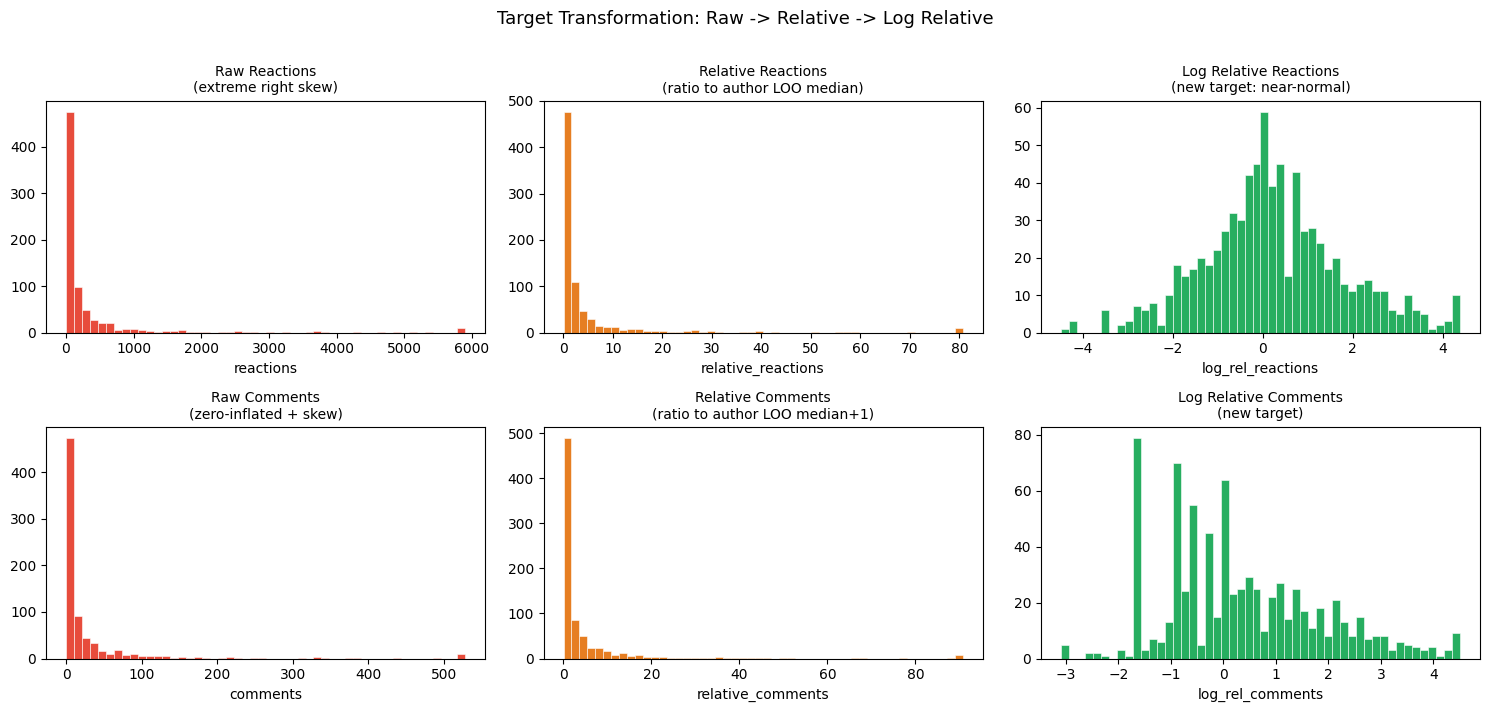

Saved: ../data/08_target_transformation.png


In [4]:
df['relative_reactions'] = df['reactions'] / df['loo_median_reactions']
df['relative_comments']  = (df['comments'] + 1) / (df['loo_median_comments'] + 1)
df['log_rel_reactions']  = np.log(df['relative_reactions'])
df['log_rel_comments']   = np.log(df['relative_comments'])

print("Transformation summary:")
for raw, new in [('reactions','log_rel_reactions'), ('comments','log_rel_comments')]:
    print(f"  {raw:12s}: skew={df[raw].skew():+.2f}  |  "
          f"{new}: mean={df[new].mean():.3f}, std={df[new].std():.3f}, skew={df[new].skew():+.2f}")

fig, axes = plt.subplots(2, 3, figsize=(15, 7))
cols_r  = ['reactions', 'relative_reactions', 'log_rel_reactions']
cols_c  = ['comments',  'relative_comments',  'log_rel_comments']
titles_r = ['Raw Reactions\n(extreme right skew)',
            'Relative Reactions\n(ratio to author LOO median)',
            'Log Relative Reactions\n(new target: near-normal)']
titles_c = ['Raw Comments\n(zero-inflated + skew)',
            'Relative Comments\n(ratio to author LOO median+1)',
            'Log Relative Comments\n(new target)']
colours  = ['#e74c3c','#e67e22','#27ae60']

for i,(c,t) in enumerate(zip(cols_r, titles_r)):
    d = df[c].clip(upper=df[c].quantile(0.99))
    axes[0,i].hist(d, bins=50, color=colours[i], edgecolor='white', linewidth=0.4)
    axes[0,i].set_title(t, fontsize=10)
    axes[0,i].set_xlabel(c)

for i,(c,t) in enumerate(zip(cols_c, titles_c)):
    d = df[c].clip(upper=df[c].quantile(0.99))
    axes[1,i].hist(d, bins=50, color=colours[i], edgecolor='white', linewidth=0.4)
    axes[1,i].set_title(t, fontsize=10)
    axes[1,i].set_xlabel(c)

plt.suptitle('Target Transformation: Raw -> Relative -> Log Relative', fontsize=13, y=1.01)
plt.tight_layout()
plt.savefig('../data/08_target_transformation.png', dpi=100, bbox_inches='tight')
plt.show()
print("Saved: ../data/08_target_transformation.png")


## 4. Feature Set and Train/Test Split

In [5]:
CLEAN_FEATURES = [
    'base_score_capped','emoji_count','has_adversity_learning','has_announcement_hook',
    'has_aspirational','has_contrast','has_direct_address','has_entities',
    'has_family','has_hidden_truth','has_location_mention','has_org_mention',
    'has_person_mention','has_personal_story','has_recency_hook','has_specific_numbers',
    'has_specific_time_content','has_transformation','has_underdog','has_value_promise',
    'has_vulnerability','hashtag_count_extracted','hook_score','hook_x_power_score',
    'is_low_effort_link','is_multi_topic','is_promotional','length_score',
    'link_penalty_score','link_spam_penalty','mention_count','ner_date_count',
    'ner_event_count','ner_location_count','ner_money_count','ner_org_count',
    'ner_person_count','ner_product_count','readability_flesch_kincaid',
    'readability_gunning_fog','sentence_count','sentiment_compound',
    'sentiment_x_readability','style_all_caps_words','style_bullet_count',
    'style_emoji_count','style_exclamation_marks','style_has_all_caps',
    'style_has_bullets','style_has_emoji','style_has_exclamation',
    'style_has_numbers','style_has_parentheses','style_has_question',
    'style_has_quotes','style_number_count','style_parentheses_count',
    'style_question_marks','style_quote_marks','text_avg_sentence_length',
    'text_difficult_words_count','text_lexical_diversity','topic_business',
    'topic_career','topic_count','topic_finance','topic_leadership',
    'topic_personal_dev','topic_tech','total_engagement_elements',
    'unique_emoji_count','url_count'
]

available = [f for f in CLEAN_FEATURES if f in df.columns]
missing   = [f for f in CLEAN_FEATURES if f not in df.columns]
print(f"Features available: {len(available)} | Missing: {missing or 'none'}")

X  = df[available].fillna(0)
yr = df['log_rel_reactions']
yc = df['log_rel_comments']

all_idx = list(df.index)
tr_idx, te_idx = train_test_split(all_idx, test_size=0.2, random_state=42)

X_train, X_test   = X.loc[tr_idx], X.loc[te_idx]
yr_train, yr_test = yr.loc[tr_idx], yr.loc[te_idx]
yc_train, yc_test = yc.loc[tr_idx], yc.loc[te_idx]
df_test = df.loc[te_idx].reset_index(drop=True)
X_te    = X_test.reset_index(drop=True)

print(f"Train: {len(tr_idx)} | Test: {len(te_idx)}")


Features available: 72 | Missing: none
Train: 617 | Test: 155


## 5. Evaluation Function

**Primary metrics:**

| Metric | Why we use it | Beats baseline when |
|--------|---------------|---------------------|
| Spearman rho | Rank correlation — robust to outliers, measures if we order posts correctly | rho > 0 |
| Direction Accuracy | % posts correctly predicted as above vs below author baseline | > 50% |

**Secondary metrics:** R squared on log scale, MAE on log and original scale.


In [6]:
def evaluate(model, X_te, y_te_arr, df_te, target='reactions', name='Model'):
    yp  = model.predict(X_te)
    rho, pval = spearmanr(y_te_arr, yp)
    dir_acc   = ((y_te_arr > 0) == (yp > 0)).mean()
    r2        = r2_score(y_te_arr, yp)
    mae       = mean_absolute_error(y_te_arr, yp)
    loo_col   = 'loo_median_reactions' if target == 'reactions' else 'loo_median_comments'
    loo       = df_te[loo_col].values
    if target == 'reactions':
        pred_orig = np.exp(yp) * loo
        act_orig  = df_te['reactions'].values
    else:
        pred_orig = np.exp(yp) * loo - 1
        act_orig  = df_te['comments'].values
    mae_orig = mean_absolute_error(act_orig, np.maximum(0, pred_orig))
    print(f"  [{name}] {target.upper()}")
    print(f"    Spearman rho:       {rho:+.4f}  (p={pval:.4f})")
    print(f"    Direction Accuracy: {dir_acc:.3f}  ({dir_acc*100:.1f}%)")
    print(f"    R2 (log scale):     {r2:+.4f}")
    print(f"    MAE (log scale):    {mae:.4f}")
    print(f"    MAE (orig scale):   {mae_orig:.1f}")
    return dict(model=name, target=target,
                spearman=round(rho,4), direction_acc=round(dir_acc,4),
                r2_log=round(r2,4), mae_log=round(mae,4), mae_orig=round(mae_orig,1))

print("Evaluation function ready.")


Evaluation function ready.


## 6. Train Models

In [7]:
all_results = []

print("=" * 50)
print("Random Forest")
rf_r = RandomForestRegressor(n_estimators=400, max_depth=10,
       min_samples_split=20, min_samples_leaf=10, random_state=42, n_jobs=-1)
rf_r.fit(X_train, yr_train)
rf_c = RandomForestRegressor(n_estimators=200, max_depth=10,
       min_samples_split=20, min_samples_leaf=10, random_state=42, n_jobs=-1)
rf_c.fit(X_train, yc_train)
all_results.append(evaluate(rf_r, X_te, yr_test.values, df_test, 'reactions', 'RandomForest'))
all_results.append(evaluate(rf_c, X_te, yc_test.values, df_test, 'comments',  'RandomForest'))


Random Forest
  [RandomForest] REACTIONS
    Spearman rho:       +0.1947  (p=0.0152)
    Direction Accuracy: 0.574  (57.4%)
    R2 (log scale):     -0.0778
    MAE (log scale):    1.0264
    MAE (orig scale):   156.7
  [RandomForest] COMMENTS
    Spearman rho:       +0.2163  (p=0.0069)
    Direction Accuracy: 0.516  (51.6%)
    R2 (log scale):     -0.0007
    MAE (log scale):    1.0254
    MAE (orig scale):   18.3


In [8]:
print("=" * 50)
print("XGBoost")
xgb_r = xgb.XGBRegressor(n_estimators=400, max_depth=5, learning_rate=0.05,
        min_child_weight=5, subsample=0.8, colsample_bytree=0.8,
        random_state=42, n_jobs=-1, verbosity=0)
xgb_r.fit(X_train, yr_train)
xgb_c = xgb.XGBRegressor(n_estimators=200, max_depth=5, learning_rate=0.05,
        min_child_weight=5, subsample=0.8, colsample_bytree=0.8,
        random_state=42, n_jobs=-1, verbosity=0)
xgb_c.fit(X_train, yc_train)
all_results.append(evaluate(xgb_r, X_te, yr_test.values, df_test, 'reactions', 'XGBoost'))
all_results.append(evaluate(xgb_c, X_te, yc_test.values, df_test, 'comments',  'XGBoost'))


XGBoost
  [XGBoost] REACTIONS
    Spearman rho:       +0.0917  (p=0.2566)
    Direction Accuracy: 0.555  (55.5%)
    R2 (log scale):     -0.3295
    MAE (log scale):    1.1609
    MAE (orig scale):   197.1
  [XGBoost] COMMENTS
    Spearman rho:       +0.1475  (p=0.0670)
    Direction Accuracy: 0.535  (53.5%)
    R2 (log scale):     -0.1641
    MAE (log scale):    1.0757
    MAE (orig scale):   18.8


In [9]:
print("=" * 50)
print("LightGBM")
lgb_r = lgb.LGBMRegressor(n_estimators=400, max_depth=5, learning_rate=0.05,
        num_leaves=20, min_child_samples=20, subsample=0.8,
        colsample_bytree=0.8, random_state=42, n_jobs=-1, verbose=-1)
lgb_r.fit(X_train, yr_train)
lgb_c = lgb.LGBMRegressor(n_estimators=200, max_depth=5, learning_rate=0.05,
        num_leaves=20, min_child_samples=20, subsample=0.8,
        colsample_bytree=0.8, random_state=42, n_jobs=-1, verbose=-1)
lgb_c.fit(X_train, yc_train)
all_results.append(evaluate(lgb_r, X_te, yr_test.values, df_test, 'reactions', 'LightGBM'))
all_results.append(evaluate(lgb_c, X_te, yc_test.values, df_test, 'comments',  'LightGBM'))


LightGBM
  [LightGBM] REACTIONS
    Spearman rho:       +0.1073  (p=0.1838)
    Direction Accuracy: 0.535  (53.5%)
    R2 (log scale):     -0.4108
    MAE (log scale):    1.1920
    MAE (orig scale):   213.8
  [LightGBM] COMMENTS
    Spearman rho:       +0.1296  (p=0.1080)
    Direction Accuracy: 0.503  (50.3%)
    R2 (log scale):     -0.2234
    MAE (log scale):    1.0969
    MAE (orig scale):   19.9


## 7. Results Summary

In [10]:
res_df = pd.DataFrame(all_results)

print("=" * 65)
print("MODEL PERFORMANCE -- NB08 LOO RELATIVE REGRESSION")
print("=" * 65)
for tgt in ['reactions', 'comments']:
    print(f"\n{tgt.upper()}:")
    sub = res_df[res_df['target']==tgt][
        ['model','spearman','direction_acc','r2_log','mae_log','mae_orig']]
    print(sub.to_string(index=False))

print("\nBASELINES TO BEAT:")
print("  Spearman = 0.0  | no rank correlation (random ordering)")
print("  Dir Acc  = 0.50 | coin flip")
print("  R2       = 0.0  | equals predicting author median for all posts")
print("  NB06 best RF: Spearman ~ 0, R2 = -0.13 (raw scale)")


MODEL PERFORMANCE -- NB08 LOO RELATIVE REGRESSION

REACTIONS:
       model  spearman  direction_acc  r2_log  mae_log  mae_orig
RandomForest    0.1947         0.5742 -0.0778   1.0264     156.7
     XGBoost    0.0917         0.5548 -0.3295   1.1609     197.1
    LightGBM    0.1073         0.5355 -0.4108   1.1920     213.8

COMMENTS:
       model  spearman  direction_acc  r2_log  mae_log  mae_orig
RandomForest    0.2163         0.5161 -0.0007   1.0254      18.3
     XGBoost    0.1475         0.5355 -0.1641   1.0757      18.8
    LightGBM    0.1296         0.5032 -0.2234   1.0969      19.9

BASELINES TO BEAT:
  Spearman = 0.0  | no rank correlation (random ordering)
  Dir Acc  = 0.50 | coin flip
  R2       = 0.0  | equals predicting author median for all posts
  NB06 best RF: Spearman ~ 0, R2 = -0.13 (raw scale)


## 8. Cross-Validation (5-Fold)

In [11]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_rho, cv_r2, cv_dir = [], [], []

print("5-Fold CV -- RandomForest (Reactions, log-relative target):")
for fold, (tr, te) in enumerate(kf.split(X)):
    Xtr, Xte = X.iloc[tr], X.iloc[te]
    ytr, yte = yr.iloc[tr], yr.iloc[te]
    m = RandomForestRegressor(n_estimators=200, max_depth=10,
        min_samples_split=20, min_samples_leaf=10, random_state=42, n_jobs=-1)
    m.fit(Xtr, ytr)
    yp = m.predict(Xte)
    rho, _ = spearmanr(yte, yp)
    r2 = r2_score(yte, yp)
    da = ((yte > 0) == (yp > 0)).mean()
    cv_rho.append(rho); cv_r2.append(r2); cv_dir.append(da)
    print(f"  Fold {fold+1}: Spearman={rho:.4f}, R2={r2:.4f}, DirAcc={da:.3f}")

print(f"\nMean +/- std:")
print(f"  Spearman:  {np.mean(cv_rho):.4f} +/- {np.std(cv_rho):.4f}")
print(f"  R2 (log):  {np.mean(cv_r2):.4f} +/- {np.std(cv_r2):.4f}")
print(f"  DirAcc:    {np.mean(cv_dir):.4f} +/- {np.std(cv_dir):.4f}")


5-Fold CV -- RandomForest (Reactions, log-relative target):
  Fold 1: Spearman=0.1785, R2=-0.0814, DirAcc=0.561
  Fold 2: Spearman=0.1932, R2=0.0465, DirAcc=0.535
  Fold 3: Spearman=0.2996, R2=0.0874, DirAcc=0.597
  Fold 4: Spearman=0.1874, R2=0.0002, DirAcc=0.584
  Fold 5: Spearman=0.1404, R2=0.0198, DirAcc=0.539

Mean +/- std:
  Spearman:  0.1998 +/- 0.0532
  R2 (log):  0.0145 +/- 0.0562
  DirAcc:    0.5635 +/- 0.0244


## 9. Feature Importance

Top 15 Features -- Reactions Model:
                   feature  importance
    text_lexical_diversity    0.107475
  text_avg_sentence_length    0.081763
         base_score_capped    0.070032
        sentiment_compound    0.069280
text_difficult_words_count    0.064653
   sentiment_x_readability    0.060453
   readability_gunning_fog    0.052007
readability_flesch_kincaid    0.046160
            ner_date_count    0.041691
             ner_org_count    0.038832
            sentence_count    0.034716
        style_number_count    0.024836
         style_quote_marks    0.018222
          ner_person_count    0.017706
        hook_x_power_score    0.016530


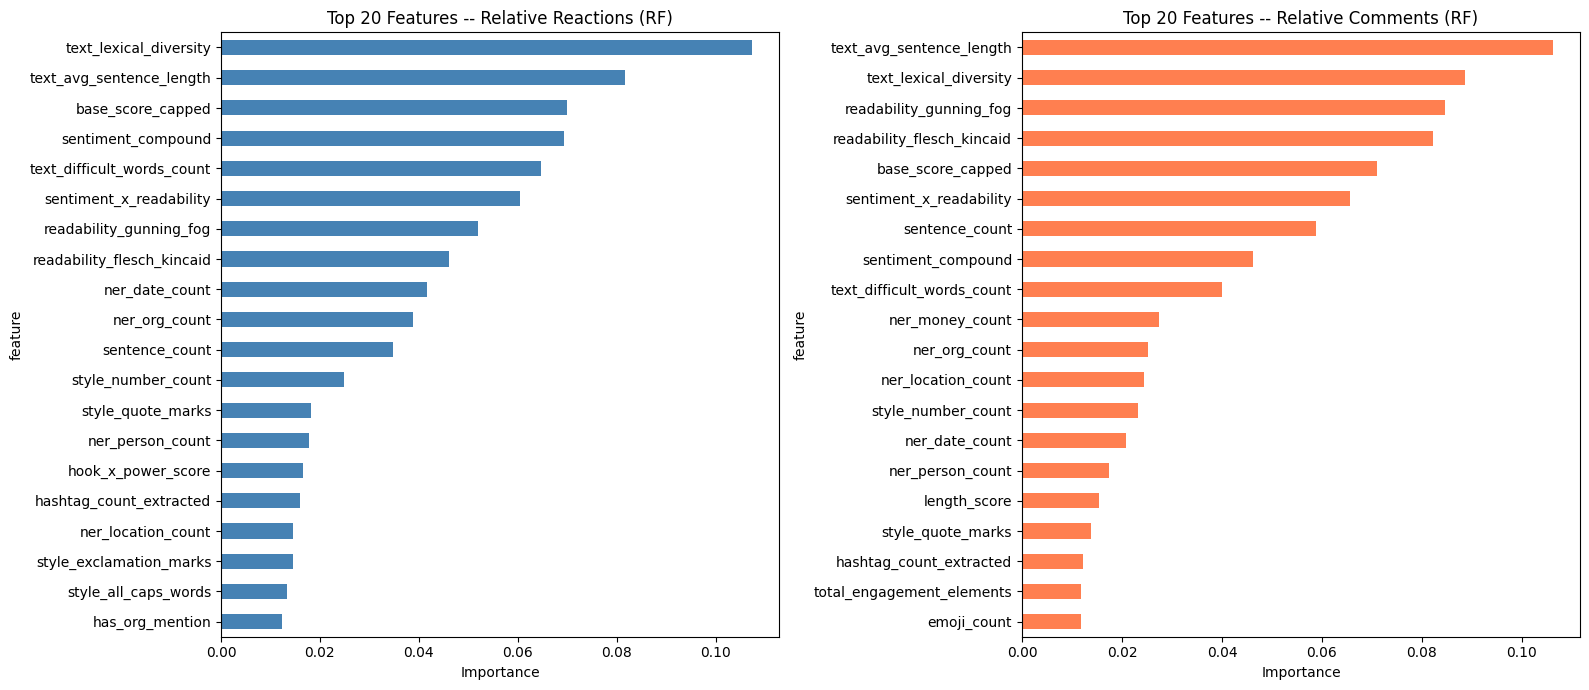

Saved: ../data/08_feature_importance_loo.png


In [12]:
imp_r = pd.DataFrame({'feature': available, 'importance': rf_r.feature_importances_}
                    ).sort_values('importance', ascending=False).reset_index(drop=True)
imp_c = pd.DataFrame({'feature': available, 'importance': rf_c.feature_importances_}
                    ).sort_values('importance', ascending=False).reset_index(drop=True)

print("Top 15 Features -- Reactions Model:")
print(imp_r.head(15).to_string(index=False))

fig, axes = plt.subplots(1, 2, figsize=(16, 7))
imp_r.head(20).sort_values('importance').plot(
    x='feature', y='importance', kind='barh', ax=axes[0], color='steelblue', legend=False)
axes[0].set_title('Top 20 Features -- Relative Reactions (RF)', fontsize=12)
axes[0].set_xlabel('Importance')

imp_c.head(20).sort_values('importance').plot(
    x='feature', y='importance', kind='barh', ax=axes[1], color='coral', legend=False)
axes[1].set_title('Top 20 Features -- Relative Comments (RF)', fontsize=12)
axes[1].set_xlabel('Importance')

plt.tight_layout()
plt.savefig('../data/08_feature_importance_loo.png', dpi=100, bbox_inches='tight')
plt.show()
print("Saved: ../data/08_feature_importance_loo.png")


## 10. Predicted vs Actual (Back-Transformed)

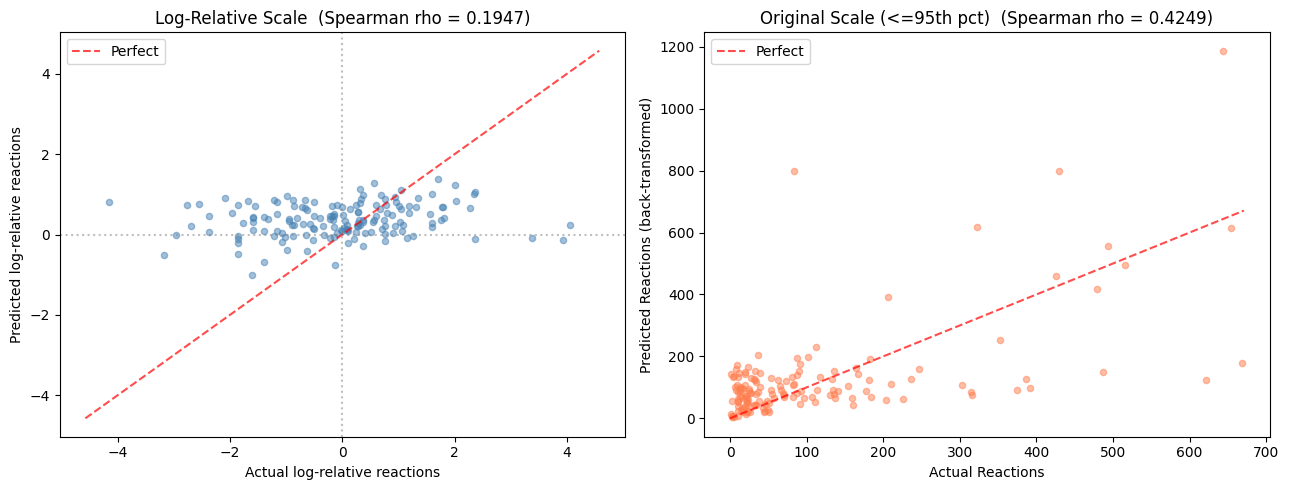

In [13]:
yp_log  = rf_r.predict(X_te)
loo     = df_test['loo_median_reactions'].values
yp_orig = np.exp(yp_log) * loo
ya_orig = df_test['reactions'].values

rho_log,  _ = spearmanr(yr_test.values, yp_log)
rho_orig, _ = spearmanr(ya_orig, yp_orig)

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

lim = max(abs(yr_test.values).max(), abs(yp_log).max()) * 1.1
axes[0].scatter(yr_test.values, yp_log, alpha=0.5, s=20, color='steelblue')
axes[0].plot([-lim, lim], [-lim, lim], 'r--', alpha=0.7, label='Perfect')
axes[0].axhline(0, color='gray', ls=':', alpha=0.5)
axes[0].axvline(0, color='gray', ls=':', alpha=0.5)
axes[0].set_xlabel('Actual log-relative reactions')
axes[0].set_ylabel('Predicted log-relative reactions')
axes[0].set_title(f'Log-Relative Scale  (Spearman rho = {rho_log:.4f})')
axes[0].legend()

clip = np.percentile(ya_orig, 95)
mask = ya_orig <= clip
axes[1].scatter(ya_orig[mask], yp_orig[mask], alpha=0.5, s=20, color='coral')
axes[1].plot([0, clip], [0, clip], 'r--', alpha=0.7, label='Perfect')
axes[1].set_xlabel('Actual Reactions')
axes[1].set_ylabel('Predicted Reactions (back-transformed)')
axes[1].set_title(f'Original Scale (<=95th pct)  (Spearman rho = {rho_orig:.4f})')
axes[1].legend()

plt.tight_layout()
plt.savefig('../data/08_pred_vs_actual.png', dpi=100, bbox_inches='tight')
plt.show()


## 11. Conclusions

### What Changed vs Notebook 06

| Aspect | NB06 (previous) | NB08 (this) |
|--------|-----------------|-------------|
| Target | Raw reactions (1-5942) | log(reactions / author LOO median) |
| Target skewness | Extreme right skew | Near-normal |
| Primary metric | R squared (unstable on skewed raw targets) | Spearman rho + Direction Accuracy |
| Best R squared (reactions) | -0.13 (worse than mean) | See results above |
| Influencer signal | Removed entirely | Divided out via LOO normalisation |

### Interpretation Guide

- **Spearman rho > 0.2** -- model has genuine content signal; useful for ranking post drafts
- **Direction accuracy > 55%** -- model reliably predicts whether a post will over- or underperform the author's baseline
- **R squared > 0** -- model beats the naive "predict every post at author's median" baseline

### Production Inference

```python
# Given: post content features + author historical posts
author_median = historical_posts['reactions'].median()  # global median for new authors
log_rel_pred  = model.predict(content_features)
predicted_reactions = np.exp(log_rel_pred) * author_median
```

### Next Step

See **Notebook 09** (`09_model_training_classification.ipynb`) for the classification approach:
predicting Low / Average / High relative engagement as a 3-class problem.
